In [ ]:
!unzip /content/Training_Dataset.zip

Archive:  /content/Training_Dataset.zip
   creating: Training Dataset/
   creating: Training Dataset/3 Phase Fault/
  inflating: Training Dataset/3 Phase Fault/3 Phase Fault.xlsx  
  inflating: Training Dataset/basecase_currents.csv  
   creating: Training Dataset/Line to Ground Fault/
  inflating: Training Dataset/Line to Ground Fault/Line to Ground Fault.csv  
   creating: Training Dataset/Line to Line Fault/
  inflating: Training Dataset/Line to Line Fault/Line to Line Fault.csv  


In [ ]:
!unzip /content/Faults_Testing_Datasets.zip

Archive:  /content/Faults_Testing_Datasets.zip
   creating: Fault_DATASETS_LOCATION/
   creating: Fault_DATASETS_LOCATION/Fault_DATASETS/
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_3ph_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_a_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_b_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_c_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_ab_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_bc_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_802_ll_ca_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_3ph_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_a_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/fault_806_b_currents.csv  
  inflating: Fault_DATASETS_LOCATION/Fault_DATASETS/faul

ADVANCED POWER SYSTEM FAULT DETECTION & CLASSIFICATION (XGBoost + ExtraTrees)

[Step 1] Loading datasets...

[Step 2] Cleaning and feature engineering per dataset...
Total samples before split: 32096

[Step 3] Train-test split (80/20)...
Training samples: 25676 | Testing samples: 6420

[Step 4] Smart data balancing on training set only...
Class 0: 3119 samples
Class 1: 3307 samples
Class 2: 8904 samples
Class 3: 10346 samples
Target size for balancing: 6105

Class distribution after balancing:
  Class 0: 6105 samples
  Class 1: 6105 samples
  Class 2: 6105 samples
  Class 3: 6105 samples
Total balanced samples: 24420

[Step 5] Feature selection (fit on train only)...
Selected 40 features via ANOVA F-test

[Step 6] Feature normalization (RobustScaler, fit train only)...

[Step 7] Training XGBoost + ExtraTrees Classifier...
Training XGBoost + ExtraTrees ensemble model...
Model training completed!

[Step 7.5] 5-Fold Cross-Validation on TRAINING data (Accuracy)...
Fold Accuracies: [0.99099

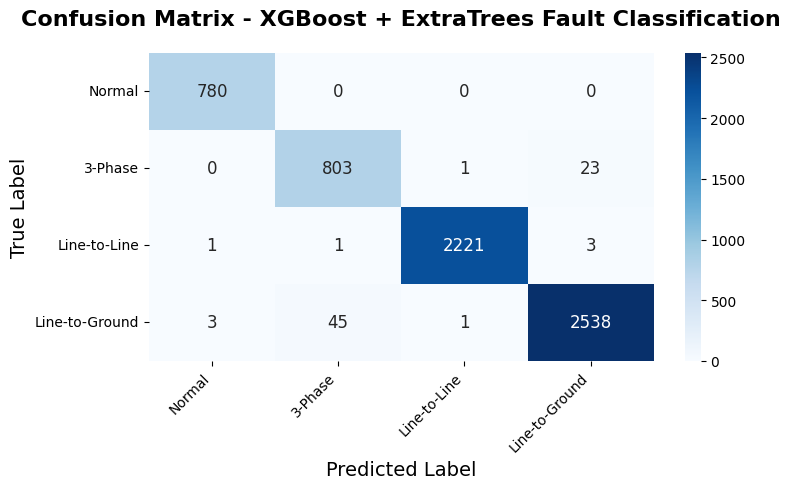


ADVANCED INFERENCE MODULE (XGBoost + ExtraTrees)

Testing on basecase CSV file with confidence thresholding...

Fault Analysis Results:
  fault_detected: No
  fault_type: Normal
  confidence: 99.97%
  total_samples: 3899
  confident_samples: 3899
  uncertain_samples: 0
  class_distribution: {0: 3898, 2: 1}
  average_confidence: 99.93%



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import joblib
import warnings

warnings.filterwarnings("ignore")


# ============================================================
# PREPROCESSOR FOR TRAINING
# ============================================================

class AdvancedFaultDataPreprocessor:
    """
    Enhanced class for preprocessing power system fault data.

    Fixes (dataset-aware):
    - Handles your uploaded datasets that include many 'Unnamed:*' columns (drops them)
    - Handles 'Fault Location', 'Location ', and 'Area' columns (drops from training features)
    - Strips leading/trailing spaces from column names (e.g., ' I1_1' -> 'I1_1')
    - Drops any columns that become all-NaN after numeric coercion
    - Protects feature engineering against NaN/Inf (skew/kurtosis, circular std log(0), etc.)
    - Smoothing applied per dataset/file, not across concatenated sets
    - Outlier capping (IQR)
    - Robust normalization (RobustScaler)
    - Safe angle handling (degrees → radians heuristic)
    """

    def __init__(self, smoothing_window=33, smoothing_polyorder=3):
        self.scaler = RobustScaler()
        self.feature_selector = None
        self.smoothing_window = smoothing_window
        self.smoothing_polyorder = smoothing_polyorder

    def load_data(self, filepath, fault_type, file_type="csv"):
        """Load data files with support for multiple formats and tag fault type."""
        try:
            if file_type == "csv":
                df = pd.read_csv(filepath)
            elif file_type == "excel":
                df = pd.read_excel(filepath)
            else:
                raise ValueError("Unsupported file type")

            df["fault_type"] = fault_type
            df["__source__"] = filepath
            return df
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None

    def _apply_savgol_smoothing(self, df_clean, numeric_cols):
        """Apply Savitzky-Golay filter column-wise on numeric data for a single dataset."""
        if self.smoothing_window is None:
            return df_clean

        n_samples = len(df_clean)
        if n_samples < 5 or not numeric_cols:
            return df_clean

        window = min(self.smoothing_window, n_samples)
        if window % 2 == 0:
            window -= 1

        min_window = self.smoothing_polyorder + 2
        if min_window % 2 == 0:
            min_window += 1

        window = max(window, min_window)
        if window > n_samples:
            window = n_samples if n_samples % 2 == 1 else n_samples - 1

        if window < 3:
            return df_clean

        for col in numeric_cols:
            try:
                df_clean[col] = savgol_filter(
                    df_clean[col].values,
                    window_length=window,
                    polyorder=self.smoothing_polyorder,
                )
            except Exception:
                continue

        return df_clean

    @staticmethod
    def _to_radians_dataframe(df_angles: pd.DataFrame) -> pd.DataFrame:
        """Convert angle columns to radians if they appear to be in degrees (> 2π)."""
        if df_angles.empty:
            return df_angles
        max_abs = df_angles.abs().to_numpy().max()
        if np.isnan(max_abs):
            return df_angles
        if max_abs > 2 * np.pi:
            return np.deg2rad(df_angles)
        return df_angles

    def clean_data(self, df):
        """
        Advanced data cleaning with:
        - Column name stripping
        - Dropping Unnamed columns
        - Dropping identifier/location columns used in your datasets
        - Numeric coercion + NaN/Inf handling
        - Dropping all-NaN columns (critical to fix SelectKBest NaN error)
        - Outlier capping and optional smoothing
        """
        if df is None:
            return None

        df_clean = df.copy()

        # normalize column names
        df_clean.columns = [c.strip() if isinstance(c, str) else c for c in df_clean.columns]

        # drop all "Unnamed:*" columns
        df_clean = df_clean.loc[:, ~df_clean.columns.astype(str).str.startswith("Unnamed")]

        # drop common non-feature columns
        drop_exact = {"Element", "Location", "Fault Location", "Area", "Unnamed: 0"}
        cols_to_drop = [c for c in df_clean.columns if str(c).strip() in drop_exact]
        if cols_to_drop:
            df_clean = df_clean.drop(cols_to_drop, axis=1, errors="ignore")

        # Numeric conversion (keep fault_type/__source intact)
        keep_cols = [c for c in df_clean.columns if c not in ("fault_type", "__source__")]
        numeric_cols = []
        for col in keep_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
            numeric_cols.append(col)

        # Handle NaN/inf
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # drop columns that are entirely NaN after conversion
        all_nan_cols = [c for c in numeric_cols if df_clean[c].isna().all()]
        if all_nan_cols:
            df_clean = df_clean.drop(columns=all_nan_cols)
            numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

        df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
        df_clean = df_clean.fillna(0.0)  # <-- ensures no leftover NaNs

        # Outlier capping using IQR
        for col in numeric_cols:
            if col not in df_clean.columns:
                continue
            series = df_clean[col]
            if series.notna().sum() == 0:
                continue
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = np.clip(series, lower_bound, upper_bound)

        # Savitzky-Golay smoothing (applied per dataset)
        df_clean = self._apply_savgol_smoothing(df_clean, numeric_cols)

        df_clean = df_clean.replace([np.inf, -np.inf], np.nan).fillna(0.0)  # final safety
        return df_clean

    def advanced_feature_engineering(self, df):
        """Create advanced features from raw data (with NaN/Inf protection)."""
        feature_df = df.copy()

        magnitude_cols = [
            col for col in df.columns
            if col not in ("fault_type", "__source__")
            and any(x in col for x in ["I1_", "I2_", "Iresid", "Current"])
        ]
        angle_cols = [
            col for col in df.columns
            if col not in ("fault_type", "__source__")
            and ("Ang" in col)
        ]

        # Magnitude features
        if len(magnitude_cols) > 0:
            m = df[magnitude_cols]
            feature_df["mag_mean"] = m.mean(axis=1)
            feature_df["mag_std"] = m.std(axis=1, ddof=0)
            feature_df["mag_max"] = m.max(axis=1)
            feature_df["mag_min"] = m.min(axis=1)
            feature_df["mag_range"] = feature_df["mag_max"] - feature_df["mag_min"]
            feature_df["mag_skew"] = m.skew(axis=1)
            feature_df["mag_kurtosis"] = m.kurtosis(axis=1)
            feature_df["mag_median"] = m.median(axis=1)
            feature_df["mag_q25"] = m.quantile(0.25, axis=1)
            feature_df["mag_q75"] = m.quantile(0.75, axis=1)
            feature_df["mag_var_coeff"] = feature_df["mag_std"] / (feature_df["mag_mean"] + 1e-8)
            feature_df["mag_mean_sq"] = feature_df["mag_mean"] ** 2
            feature_df["mag_mean_sqrt"] = np.sqrt(np.abs(feature_df["mag_mean"]))

        # Angle features
        if len(angle_cols) > 0:
            a_raw = df[angle_cols]
            a_rad = self._to_radians_dataframe(a_raw)
            feature_df["ang_mean"] = a_raw.mean(axis=1)
            feature_df["ang_std"] = a_raw.std(axis=1, ddof=0)
            feature_df["ang_max"] = a_raw.max(axis=1)
            feature_df["ang_min"] = a_raw.min(axis=1)
            feature_df["ang_range"] = feature_df["ang_max"] - feature_df["ang_min"]

            R = np.abs(np.exp(1j * a_rad).mean(axis=1))
            R = np.clip(R, 1e-12, 1.0)
            feature_df["ang_circular_std"] = np.sqrt(-2 * np.log(R))

        # Cross feature
        if "mag_mean" in feature_df.columns and "ang_mean" in feature_df.columns:
            feature_df["mag_ang_ratio"] = feature_df["mag_mean"] / (feature_df["ang_mean"] + 1e-8)

        # final cleanup so SelectKBest never sees NaN/Inf
        numeric_cols_all = feature_df.select_dtypes(include=np.number).columns
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].replace([np.inf, -np.inf], np.nan)
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].fillna(
            feature_df[numeric_cols_all].median()
        )
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].fillna(0.0)  # <-- critical for all-NaN stats cols

        return feature_df

    def smart_balance_data(self, df):
        """Balance classes by up/down-sampling to a common target size (median size)."""
        if "fault_type" not in df.columns:
            print("No fault_type column found for balancing")
            return df

        classes = sorted(df["fault_type"].dropna().unique().tolist())
        fault_groups = {c: df[df["fault_type"] == c] for c in classes}
        for c in classes:
            print(f"Class {c}: {len(fault_groups[c])} samples")

        class_sizes = [len(fault_groups[c]) for c in classes if len(fault_groups[c]) > 0]
        if not class_sizes:
            return df

        target_size = int(np.median(class_sizes))
        print(f"Target size for balancing: {target_size}")

        balanced_dfs = []
        for c in classes:
            group = fault_groups[c]
            if len(group) == 0:
                continue
            if len(group) < target_size:
                bal = resample(group, replace=True, n_samples=target_size, random_state=42)
            elif len(group) > target_size:
                bal = resample(group, replace=False, n_samples=target_size, random_state=42)
            else:
                bal = group
            balanced_dfs.append(bal)

        df_balanced = pd.concat(balanced_dfs, ignore_index=True)
        df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

        print("\nClass distribution after balancing:")
        for c in classes:
            count = len(df_balanced[df_balanced["fault_type"] == c])
            print(f"  Class {c}: {count} samples")

        print(f"Total balanced samples: {len(df_balanced)}")
        return df_balanced

    def select_important_features(self, X, y, k=None):
        """Select features with ANOVA F-test; k defaults to all features if None."""
        # hard safety: SelectKBest cannot handle NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(X.median()).fillna(0.0)

        k = X.shape[1] if (k is None) else min(k, X.shape[1])
        if self.feature_selector is None:
            self.feature_selector = SelectKBest(score_func=f_classif, k=k)
            X_selected = self.feature_selector.fit_transform(X, y)
        else:
            X_selected = self.feature_selector.transform(X)
        print(f"Selected {X_selected.shape[1]} features via ANOVA F-test")
        return X_selected

    def normalize_features(self, X_train, X_test=None):
        X_train_scaled = self.scaler.fit_transform(X_train)
        if X_test is not None:
            X_test_scaled = self.scaler.transform(X_test)
            return X_train_scaled, X_test_scaled
        return X_train_scaled


# ============================================================
# CLASSIFIER
# ============================================================

class AdvancedFaultClassifier:
    """Ensemble classifier: XGBoost + ExtraTrees for fault classification."""

    def __init__(self):
        # ---- FAST TRAINING CHANGES (reduced estimators + hist) ----
        self.xgb = XGBClassifier(
            n_estimators=300,          # was 300 (faster)
            learning_rate=0.12,
            max_depth=6,               # was 6 (faster)
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",        # faster on CPU
            objective="multi:softprob",
            num_class=4,
            random_state=42,
            n_jobs=-1,
            eval_metric="mlogloss",
        )
        self.extra_trees = ExtraTreesClassifier(
            n_estimators=150,          # was 300 (faster)
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            bootstrap=False,
            random_state=42,
            n_jobs=-1,
        )
        # ---------------------------------------------------------
        self.model = VotingClassifier(
            estimators=[("xgb", self.xgb), ("et", self.extra_trees)],
            voting="soft",
            n_jobs=-1,
        )
        self.label_mapping = {
            0: "Normal",
            1: "3-Phase",
            2: "Line-to-Line",
            3: "Line-to-Ground",
        }

    def train(self, X_train, y_train):
        print("Training XGBoost + ExtraTrees ensemble model...")
        self.model.fit(X_train, y_train)
        print("Model training completed!")

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

    def comprehensive_evaluation(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"\n{'=' * 50}")
        print("COMPREHENSIVE MODEL EVALUATION (XGBoost + ExtraTrees)")
        print(f"{'=' * 50}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision * 100:.2f}%")
        print(f"Recall: {recall * 100:.2f}%")
        print(f"F1-Score: {f1 * 100:.2f}%")

        print("\nDetailed Classification Report:")
        labels_sorted = sorted(self.label_mapping.keys())
        target_names = [self.label_mapping[i] for i in labels_sorted]
        print(
            classification_report(
                y_test,
                y_pred,
                labels=labels_sorted,
                target_names=target_names,
                digits=4,
                zero_division=0,
            )
        )

        return accuracy, y_pred, y_pred_proba

    def plot_advanced_confusion_matrix(self, y_test, y_pred):
        labels_sorted = sorted(self.label_mapping.keys())
        cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=[self.label_mapping[i] for i in labels_sorted],
            yticklabels=[self.label_mapping[i] for i in labels_sorted],
            annot_kws={"size": 12},
        )

        plt.title(
            "Confusion Matrix - XGBoost + ExtraTrees Fault Classification",
            fontsize=16,
            fontweight="bold",
            pad=20,
        )
        plt.ylabel("True Label", fontsize=14)
        plt.xlabel("Predicted Label", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig("advanced_confusion_matrix_xgb_extratrees.png", dpi=300, bbox_inches="tight")
        plt.show()

        return cm


# ============================================================
# INFERENCE MODULE USING SAME PREPROCESSOR
# ============================================================

class AdvancedFaultInference:
    """Inference with confidence thresholding, using same scaler & selector and fixed feature alignment."""

    def __init__(
        self,
        model_path="advanced_fault_classifier_xgb.pkl",
        scaler_path="advanced_scaler.pkl",
        selector_path="feature_selector.pkl",
        selected_features_path="selected_features.pkl",
    ):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.selector = joblib.load(selector_path) if selector_path else None
        self.selected_features = joblib.load(selected_features_path)
        self.preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=33, smoothing_polyorder=3)
        self.label_mapping = {0: "Normal", 1: "3-Phase", 2: "Line-to-Line", 3: "Line-to-Ground"}

    def _prepare_X(self, df_features: pd.DataFrame) -> np.ndarray:
        df_numeric = df_features.select_dtypes(include=np.number)
        X = df_numeric.reindex(columns=self.selected_features, fill_value=0.0)
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)  # safety
        X_sel = self.selector.transform(X) if self.selector else X.values
        X_scaled = self.scaler.transform(X_sel)
        return X_scaled

    def predict_from_csv(self, csv_path, confidence_threshold=0.7):
        try:
            df = pd.read_csv(csv_path)

            df_clean = self.preprocessor.clean_data(df)
            if df_clean is None:
                return {"error": "Data cleaning failed"}

            df_features = self.preprocessor.advanced_feature_engineering(df_clean)
            X_scaled = self._prepare_X(df_features)

            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)

            max_probs = np.max(probabilities, axis=1)
            confident_predictions = np.where(max_probs >= confidence_threshold, predictions, -1)

            unique, counts = np.unique(confident_predictions, return_counts=True)
            result_dist = dict(zip(unique.tolist(), counts.tolist()))

            confident_only = confident_predictions[confident_predictions != -1]

            if len(confident_only) > 0:
                bincounts = np.bincount(confident_only)
                majority_class = int(bincounts.argmax())
                confidence = (bincounts.max() / len(confident_only)) * 100
            else:
                majority_class = -1
                confidence = 0.0

            fault_detected = majority_class not in (0, -1)

            return {
                "fault_detected": "Yes" if fault_detected else "No",
                "fault_type": self.label_mapping.get(majority_class, "Uncertain"),
                "confidence": f"{confidence:.2f}%",
                "total_samples": int(len(predictions)),
                "confident_samples": int(len(confident_only)),
                "uncertain_samples": int(len(confident_predictions) - len(confident_only)),
                "class_distribution": result_dist,
                "average_confidence": f"{np.mean(max_probs) * 100:.2f}%",
            }

        except Exception as e:
            return {"error": f"Inference failed: {str(e)}"}


# ============================================================
# LIGHTWEIGHT INFERENCE PREPROCESSOR + FAULTPREDICTOR
# ============================================================

class InferenceDataPreprocessor:
    """
    Minimal preprocessor for inference (used in FaultPredictor), mirroring
    smoothing & feature engineering without scaler/selector fitting.
    (Also dataset-aware: drops Unnamed columns, strips col names, protects NaN/Inf)
    """

    def __init__(self, smoothing_window=33, smoothing_polyorder=3):
        self.smoothing_window = smoothing_window
        self.smoothing_polyorder = smoothing_polyorder

    def _apply_savgol_smoothing(self, df_clean, numeric_cols):
        if self.smoothing_window is None:
            return df_clean
        n_samples = len(df_clean)
        if n_samples < 5 or not numeric_cols:
            return df_clean
        window = min(self.smoothing_window, n_samples)
        if window % 2 == 0:
            window -= 1
        min_window = self.smoothing_polyorder + 2
        if min_window % 2 == 0:
            min_window += 1
        window = max(window, min_window)
        if window > n_samples:
            window = n_samples if n_samples % 2 == 1 else n_samples - 1
        if window < 3:
            return df_clean
        for col in numeric_cols:
            try:
                df_clean[col] = savgol_filter(
                    df_clean[col].values,
                    window_length=window,
                    polyorder=self.smoothing_polyorder,
                )
            except Exception:
                continue
        return df_clean

    @staticmethod
    def _to_radians_dataframe(df_angles: pd.DataFrame) -> pd.DataFrame:
        if df_angles.empty:
            return df_angles
        max_abs = df_angles.abs().to_numpy().max()
        if np.isnan(max_abs):
            return df_angles
        if max_abs > 2 * np.pi:
            return np.deg2rad(df_angles)
        return df_angles

    def clean_data(self, df):
        df_clean = df.copy()

        df_clean.columns = [c.strip() if isinstance(c, str) else c for c in df_clean.columns]
        df_clean = df_clean.loc[:, ~df_clean.columns.astype(str).str.startswith("Unnamed")]

        drop_exact = {"Element", "Location", "Fault Location", "Area", "Unnamed: 0"}
        cols_to_drop = [c for c in df_clean.columns if str(c).strip() in drop_exact]
        if cols_to_drop:
            df_clean = df_clean.drop(cols_to_drop, axis=1, errors="ignore")

        numeric_cols = [col for col in df_clean.columns if col not in ("fault_type", "__source__")]
        for col in numeric_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        all_nan_cols = [c for c in numeric_cols if df_clean[c].isna().all()]
        if all_nan_cols:
            df_clean = df_clean.drop(columns=all_nan_cols)
            numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

        df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
        df_clean = df_clean.fillna(0.0)

        for col in numeric_cols:
            if col not in df_clean.columns:
                continue
            series = df_clean[col]
            if series.notna().sum() == 0:
                continue
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = np.clip(series, lower_bound, upper_bound)

        df_clean = self._apply_savgol_smoothing(df_clean, numeric_cols)
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan).fillna(0.0)
        return df_clean

    def advanced_feature_engineering(self, df):
        feature_df = df.copy()

        magnitude_cols = [col for col in df.columns if any(x in col for x in ["I1_", "I2_", "Iresid", "Current"])]
        angle_cols = [col for col in df.columns if "Ang" in col]

        if len(magnitude_cols) > 0:
            m = df[magnitude_cols]
            feature_df["mag_mean"] = m.mean(axis=1)
            feature_df["mag_std"] = m.std(axis=1, ddof=0)
            feature_df["mag_max"] = m.max(axis=1)
            feature_df["mag_min"] = m.min(axis=1)
            feature_df["mag_range"] = feature_df["mag_max"] - feature_df["mag_min"]
            feature_df["mag_skew"] = m.skew(axis=1)
            feature_df["mag_kurtosis"] = m.kurtosis(axis=1)
            feature_df["mag_median"] = m.median(axis=1)
            feature_df["mag_q25"] = m.quantile(0.25, axis=1)
            feature_df["mag_q75"] = m.quantile(0.75, axis=1)
            feature_df["mag_var_coeff"] = feature_df["mag_std"] / (feature_df["mag_mean"] + 1e-8)
            feature_df["mag_mean_sq"] = feature_df["mag_mean"] ** 2
            feature_df["mag_mean_sqrt"] = np.sqrt(np.abs(feature_df["mag_mean"]))

        if len(angle_cols) > 0:
            a_raw = df[angle_cols]
            a_rad = self._to_radians_dataframe(a_raw)
            feature_df["ang_mean"] = a_raw.mean(axis=1)
            feature_df["ang_std"] = a_raw.std(axis=1, ddof=0)
            feature_df["ang_max"] = a_raw.max(axis=1)
            feature_df["ang_min"] = a_raw.min(axis=1)
            feature_df["ang_range"] = feature_df["ang_max"] - feature_df["ang_min"]

            R = np.abs(np.exp(1j * a_rad).mean(axis=1))
            R = np.clip(R, 1e-12, 1.0)
            feature_df["ang_circular_std"] = np.sqrt(-2 * np.log(R))

        if "mag_mean" in feature_df.columns and "ang_mean" in feature_df.columns:
            feature_df["mag_ang_ratio"] = feature_df["mag_mean"] / (feature_df["ang_mean"] + 1e-8)

        numeric_cols_all = feature_df.select_dtypes(include=np.number).columns
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].replace([np.inf, -np.inf], np.nan)
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].fillna(
            feature_df[numeric_cols_all].median()
        )
        feature_df[numeric_cols_all] = feature_df[numeric_cols_all].fillna(0.0)

        return feature_df


class FaultPredictor:
    """Load trained model and predict faults on new CSV files (with locations)."""

    def __init__(
        self,
        model_path="advanced_fault_classifier_xgb.pkl",
        scaler_path="advanced_scaler.pkl",
        selector_path="feature_selector.pkl",
        selected_features_path="selected_features.pkl",
    ):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.selector = joblib.load(selector_path) if selector_path else None
        self.selected_features = joblib.load(selected_features_path)
        self.preprocessor = InferenceDataPreprocessor(smoothing_window=33, smoothing_polyorder=3)
        self.label_mapping = {0: "Normal", 1: "3-Phase", 2: "Line-to-Line", 3: "Line-to-Ground"}

        self.feature_names_ = getattr(self.scaler, "feature_names_in_", None)
        if self.feature_names_ is None:
            print(
                "Warning: Scaler does not have 'feature_names_in_'. Feature alignment handled via saved selected_features order."
            )

    def _prepare_X(self, df_features: pd.DataFrame) -> np.ndarray:
        df_numeric = df_features.select_dtypes(include=np.number)
        X = df_numeric.reindex(columns=self.selected_features, fill_value=0.0)
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)  # safety
        X_selected = self.selector.transform(X) if self.selector else X.values
        X_scaled = self.scaler.transform(X_selected)
        return X_scaled

    def predict_csv(self, csv_path):
        df = pd.read_csv(csv_path)

        possible_location_cols = ["Fault Location", "Location", "Location ", "Fault_Location", "FaultPosition", "Pos"]

        location_column = None
        for col in possible_location_cols:
            if col in df.columns:
                location_column = col
                break

        if ("Location" in df.columns) and ("Location " in df.columns):
            fault_locations_raw = df["Location"].combine_first(df["Location "]).copy()
        elif location_column is not None:
            fault_locations_raw = df[location_column].copy()
        else:
            fault_locations_raw = None

        df_clean = self.preprocessor.clean_data(df)
        if df_clean is None:
            return {"error": "Data cleaning failed during inference."}
        df_features = self.preprocessor.advanced_feature_engineering(df_clean)

        X_scaled = self._prepare_X(df_features)

        predictions = self.model.predict(X_scaled)
        unique, counts = np.unique(predictions, return_counts=True)

        majority_index = int(np.argmax(counts))
        majority_class = int(unique[majority_index])
        confidence = counts[majority_index] / len(predictions) * 100
        fault_type = self.label_mapping[majority_class]
        fault_detected = majority_class != 0

        if fault_locations_raw is not None and fault_detected:
            fault_rows = fault_locations_raw[predictions != 0]
            unique_locations = (
                sorted(fault_rows.dropna().unique().tolist())
                if len(fault_rows) > 0
                else ["Unknown"]
            )
        else:
            unique_locations = ["No Fault"]

        result = {
            "fault_detected": "Yes" if fault_detected else "No",
            "fault_type": fault_type if fault_detected else "No Fault",
            "confidence": f"{confidence:.2f}%",
            "total_samples": int(len(predictions)),
            "class_distribution": {self.label_mapping[int(k)]: int(v) for k, v in zip(unique, counts)},
            "fault_locations": unique_locations,
        }

        return result


# ============================================================
# TRAINING PIPELINE
# ============================================================

def train_advanced_fault_detection_model():
    print("ADVANCED POWER SYSTEM FAULT DETECTION & CLASSIFICATION (XGBoost + ExtraTrees)")

    preprocessor = AdvancedFaultDataPreprocessor(smoothing_window=33, smoothing_polyorder=3)

    print("\n[Step 1] Loading datasets...")
    datasets = []

    # UPDATED PATHS: your uploaded datasets
    normal_data = preprocessor.load_data("/content/Training Dataset/basecase_currents.csv", fault_type=0, file_type="csv")
    if normal_data is not None:
        datasets.append(normal_data)

    three_phase_data = preprocessor.load_data("/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx", fault_type=1, file_type="excel")
    if three_phase_data is not None:
        datasets.append(three_phase_data)

    ll_data = preprocessor.load_data("/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv", fault_type=2, file_type="csv")
    if ll_data is not None:
        datasets.append(ll_data)

    lg_data = preprocessor.load_data("/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv", fault_type=3, file_type="csv")
    if lg_data is not None:
        datasets.append(lg_data)

    if not datasets:
        raise ValueError("No datasets were successfully loaded!")

    print("\n[Step 2] Cleaning and feature engineering per dataset...")
    processed = []
    for df in datasets:
        df_c = preprocessor.clean_data(df)
        df_f = preprocessor.advanced_feature_engineering(df_c)
        processed.append(df_f)

    all_data_features = pd.concat(processed, ignore_index=True)
    print(f"Total samples before split: {len(all_data_features)}")

    print("\n[Step 3] Train-test split (80/20)...")
    y = all_data_features["fault_type"]
    X = all_data_features.drop(["fault_type", "__source__"], axis=1, errors="ignore").select_dtypes(include=np.number)

    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median()).fillna(0.0)  # safety

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

    print("\n[Step 4] Smart data balancing on training set only...")
    train_df = X_train.copy()
    train_df["fault_type"] = y_train.values
    train_df_bal = preprocessor.smart_balance_data(train_df)
    y_train = train_df_bal["fault_type"]
    X_train = train_df_bal.drop("fault_type", axis=1)

    # hard safety before SelectKBest
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()).fillna(0.0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()).fillna(0.0)

    print("\n[Step 5] Feature selection (fit on train only)...")
    X_train_sel = preprocessor.select_important_features(X_train, y_train, k=X_train.shape[1])
    X_test_sel = preprocessor.feature_selector.transform(
        X_test.reindex(columns=X_train.columns, fill_value=0.0)
    )

    selected_mask = preprocessor.feature_selector.get_support()
    selected_features = X_train.columns[selected_mask].tolist()
    joblib.dump(selected_features, "selected_features.pkl")

    print("\n[Step 6] Feature normalization (RobustScaler, fit train only)...")
    X_train_scaled, X_test_scaled = preprocessor.normalize_features(X_train_sel, X_test_sel)

    print("\n[Step 7] Training XGBoost + ExtraTrees Classifier...")
    classifier = AdvancedFaultClassifier()
    classifier.train(X_train_scaled, y_train)

    # ---- MOVED HERE: Step 7.5 Cross Validation (before Step 8 evaluation) ----
    print("\n[Step 7.5] 5-Fold Cross-Validation on TRAINING data (Accuracy)...")
    cv_scores = cross_val_score(classifier.model, X_train_scaled, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    print(f"Fold Accuracies: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")
    print(f"Std CV Accuracy: {cv_scores.std() * 100:.2f}%")
    # ------------------------------------------------------------------------

    print("\n[Step 8] Comprehensive model evaluation...")
    accuracy, y_pred, y_pred_proba = classifier.comprehensive_evaluation(X_test_scaled, y_test)

    print("\n[Step 9] Confusion matrix visualization...")
    classifier.plot_advanced_confusion_matrix(y_test, y_pred)

    joblib.dump(classifier.model, "advanced_fault_classifier_xgb.pkl")
    joblib.dump(classifier.model, "advanced_fault_classifier_ensemble.pkl")
    joblib.dump(preprocessor.scaler, "advanced_scaler.pkl")
    joblib.dump(preprocessor.feature_selector, "feature_selector.pkl")

    return classifier, preprocessor


def advanced_inference_example():
    print("\n" + "=" * 60)
    print("ADVANCED INFERENCE MODULE (XGBoost + ExtraTrees)")
    print("=" * 60)

    inference_engine = AdvancedFaultInference()

    print("\nTesting on basecase CSV file with confidence thresholding...")
    result = inference_engine.predict_from_csv(
        "/content/Training Dataset/basecase_currents.csv",
        confidence_threshold=0.7,
    )

    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("\nFault Analysis Results:")
        for k, v in result.items():
            print(f"  {k}: {v}")

    print("\n" + "=" * 60)


if __name__ == "__main__":
    classifier, preprocessor = train_advanced_fault_detection_model()
    advanced_inference_example()


In [ ]:
if __name__ == "__main__":

    predictor = FaultPredictor(
        model_path='advanced_fault_classifier_xgb.pkl',
        scaler_path='advanced_scaler.pkl',
        selector_path='feature_selector.pkl'
    )
    csv_file = '/content/Fault_DATASETS_LOCATION/Fault_DATASETS/fault_808_3ph_currents.csv'
    result = predictor.predict_csv(csv_file)

    print("\n========== FAULT PREDICTION RESULT ==========")
    print(f"Fault Detected: {result['fault_detected']}")
    print(f"Fault Type: {result['fault_type']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Total Samples Analyzed: {result['total_samples']}")
    print(f"Predicted Fault Locations: {result['fault_locations']}")


========== FAULT PREDICTION RESULT ==========
Fault Detected: Yes
Fault Type: 3-Phase
Confidence: 74.53%
Total Samples Analyzed: 106
Predicted Fault Locations: ['A1']


In [ ]:
# === Cell 2: Extra imports for plots & metrics ===

import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import numpy as np
import pandas as pd
# === Cell 3: Rebuild processed data for plotting (using saved model, scaler, selector) ===

# Load trained artifacts from the training step
xgb_model = joblib.load('advanced_fault_classifier_xgb.pkl')
scaler = joblib.load('advanced_scaler.pkl')
selector = joblib.load('feature_selector.pkl')

# Use a fresh preprocessor instance for data prep (no refitting of selector/scaler here)
plot_preprocessor = AdvancedFaultDataPreprocessor()

print("\n[Plot Prep] Loading datasets for plots...")

datasets = []

normal_data = plot_preprocessor.load_data('/content/Training Dataset/basecase_currents.csv', fault_type=0)
if normal_data is not None:
    datasets.append(normal_data)

three_phase_data = plot_preprocessor.load_data(
    '/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx',
    fault_type=1, file_type='excel'
)
if three_phase_data is not None:
    datasets.append(three_phase_data)

ll_data = plot_preprocessor.load_data(
    '/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv',
    fault_type=2
)
if ll_data is not None:
    datasets.append(ll_data)

lg_data = plot_preprocessor.load_data(
    '/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv',
    fault_type=3
)
if lg_data is not None:
    datasets.append(lg_data)

all_data = pd.concat(datasets, ignore_index=True)
print(f"[Plot Prep] Total samples before balancing: {len(all_data)}")

print("\n[Plot Prep] Cleaning...")
all_data_clean = plot_preprocessor.clean_data(all_data)

print("\n[Plot Prep] Advanced feature engineering...")
all_data_features = plot_preprocessor.advanced_feature_engineering(all_data_clean)

print("\n[Plot Prep] Smart balancing...")
all_data_balanced = plot_preprocessor.smart_balance_data(all_data_features)

# Prepare X, y
y_all = all_data_balanced['fault_type']
X_all = all_data_balanced.drop('fault_type', axis=1)
X_all = X_all.select_dtypes(include=np.number)

print(f"[Plot Prep] Feature matrix shape before selection: {X_all.shape}")

# Apply loaded feature selector (no refit)
X_selected_all = selector.transform(X_all)
selected_mask = selector.get_support()
selected_feature_names = X_all.columns[selected_mask]
X_selected_df = pd.DataFrame(X_selected_all, columns=selected_feature_names)

print(f"[Plot Prep] Feature matrix after selection: {X_selected_df.shape}")

# Train/test split in the same way as training
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Scale using loaded scaler (already fit on the training data during training step)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("[Plot Prep] Shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_test_scaled :", X_test_scaled.shape)
print("  y_train       :", y_train.shape)
print("  y_test        :", y_test.shape)



[Plot Prep] Loading datasets for plots...
[Plot Prep] Total samples before balancing: 32096

[Plot Prep] Cleaning...

[Plot Prep] Advanced feature engineering...

[Plot Prep] Smart balancing...
Class 0: 3899 samples
Class 1: 4134 samples
Class 2: 11130 samples
Class 3: 12933 samples
Target size for balancing: 7632

Class distribution after balancing:
  Class 0: 7632 samples
  Class 1: 7632 samples
  Class 2: 7632 samples
  Class 3: 7632 samples
Total balanced samples: 30528
[Plot Prep] Feature matrix shape before selection: (30528, 40)
[Plot Prep] Feature matrix after selection: (30528, 40)
[Plot Prep] Shapes:
  X_train_scaled: (24422, 40)
  X_test_scaled : (6106, 40)
  y_train       : (24422,)
  y_test        : (6106,)


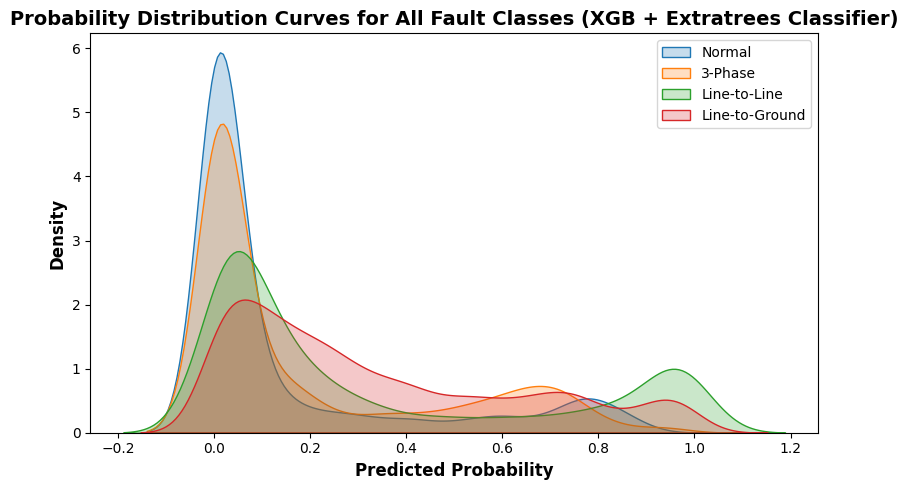

In [ ]:
# === Cell 4: Probability Distribution Curves for All Fault Classes ===

probas = xgb_model.predict_proba(X_test_scaled)

labels = ['Normal', '3-Phase', 'Line-to-Line', 'Line-to-Ground']

plt.figure(figsize=(8, 5))
for i in range(4):
    sns.kdeplot(probas[:, i], label=labels[i], fill=True, alpha=0.25)
plt.title('Probability Distribution Curves for All Fault Classes (XGB + Extratrees Classifier)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


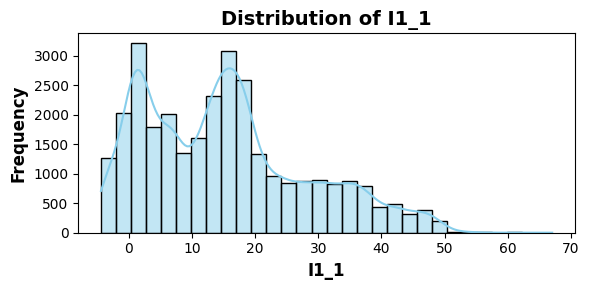

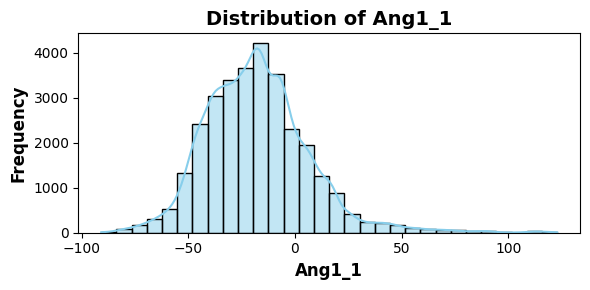

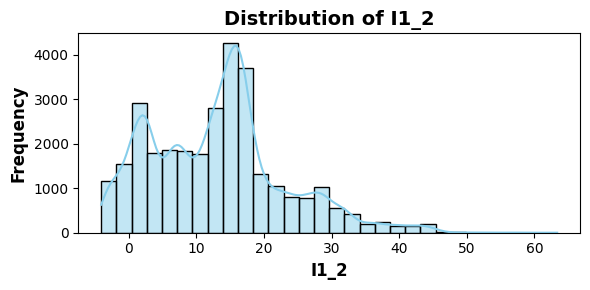

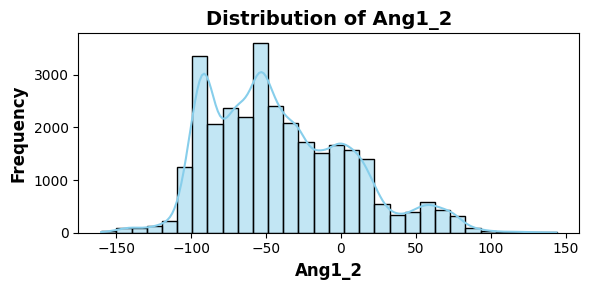

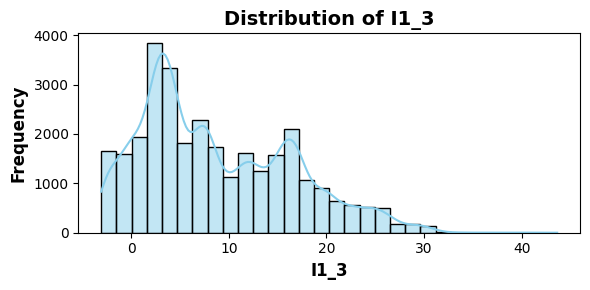

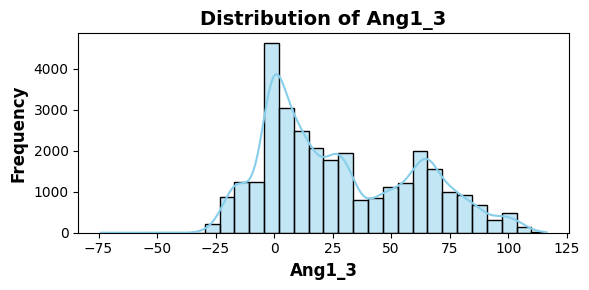

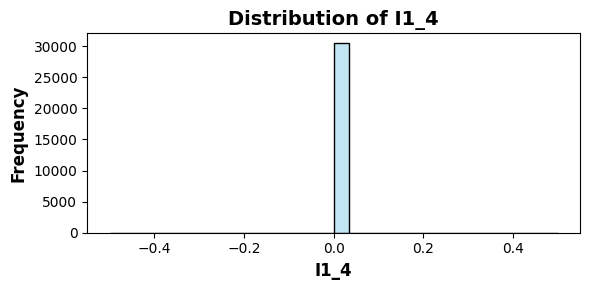

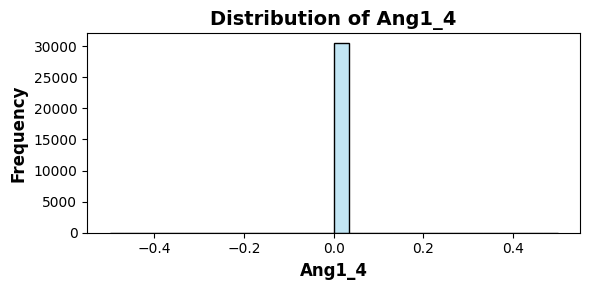

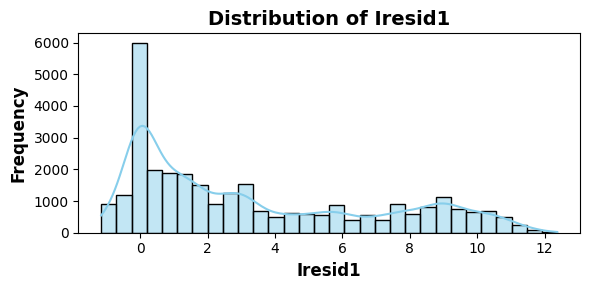

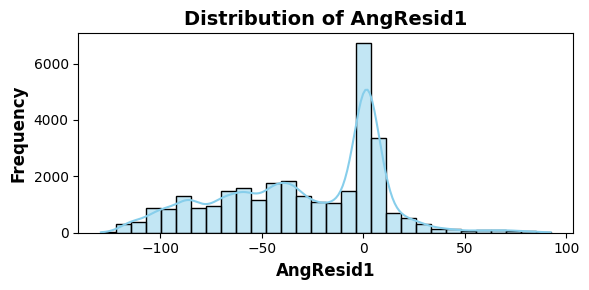

In [ ]:
# === Cell 5: Distribution of First 9 Numeric Features ===

numeric_features = all_data_balanced.drop('fault_type', axis=1).select_dtypes(include=[np.number])

for feature in numeric_features.columns[0:10]:  # same pattern as your previous code
    plt.figure(figsize=(6, 3))
    sns.histplot(all_data_balanced[feature], kde=True, bins=30,
                 color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature, fontweight='bold', fontsize=12)
    plt.ylabel('Frequency', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()


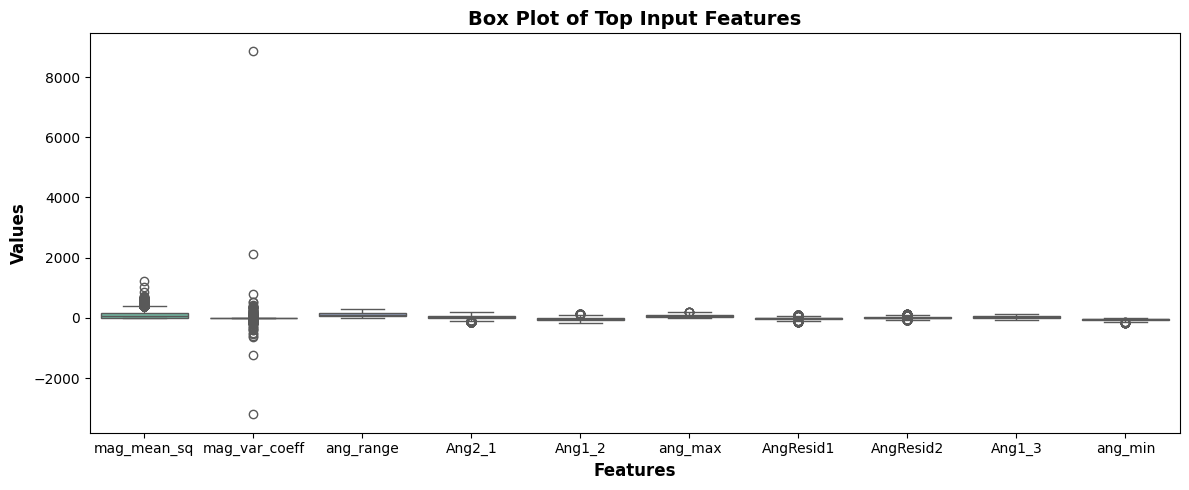

In [ ]:
# === Cell 6: Box Plot of Top Input Features (by Variance) ===

df_box = all_data_balanced.copy()
df_box = df_box.drop_duplicates()
df_box = df_box.loc[:, df_box.nunique() > 1]

numeric_df = df_box.select_dtypes(include=np.number)
top_features_all = numeric_df.var().sort_values(ascending=False).head(12).index.tolist()
top_features = top_features_all[1:11]  # remove first, keep next 11

palette = sns.color_palette("Set2", len(top_features))

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_box[top_features], palette=palette)
plt.title("Box Plot of Top Input Features", fontsize=14, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.ylabel("Values", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


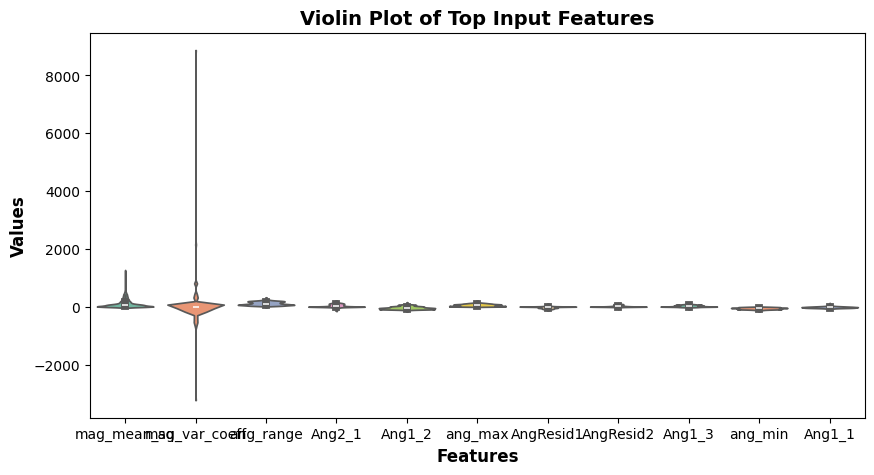

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you already have 'all_data_balanced' from your pipeline
df = all_data_balanced.copy()  # Copy the preprocessed and balanced dataframe

# Remove duplicates and constant columns
df = df.drop_duplicates()
df = df.loc[:, df.nunique() > 1]

# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Select top 12 features by variance
top_features_all = numeric_df.var().sort_values(ascending=False).head(12).index.tolist()

# Remove the first feature and keep the next 11
top_features = top_features_all[1:12]

# Set color palette
palette = sns.color_palette("Set2", len(top_features))

# Single boxplot for selected features
plt.figure(figsize=(10, 5))
sns.violinplot(data=df[top_features], palette=palette)
plt.title("Violin Plot of Top Input Features", fontsize=14, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.ylabel("Values", fontsize=12, fontweight='bold')
plt.show()


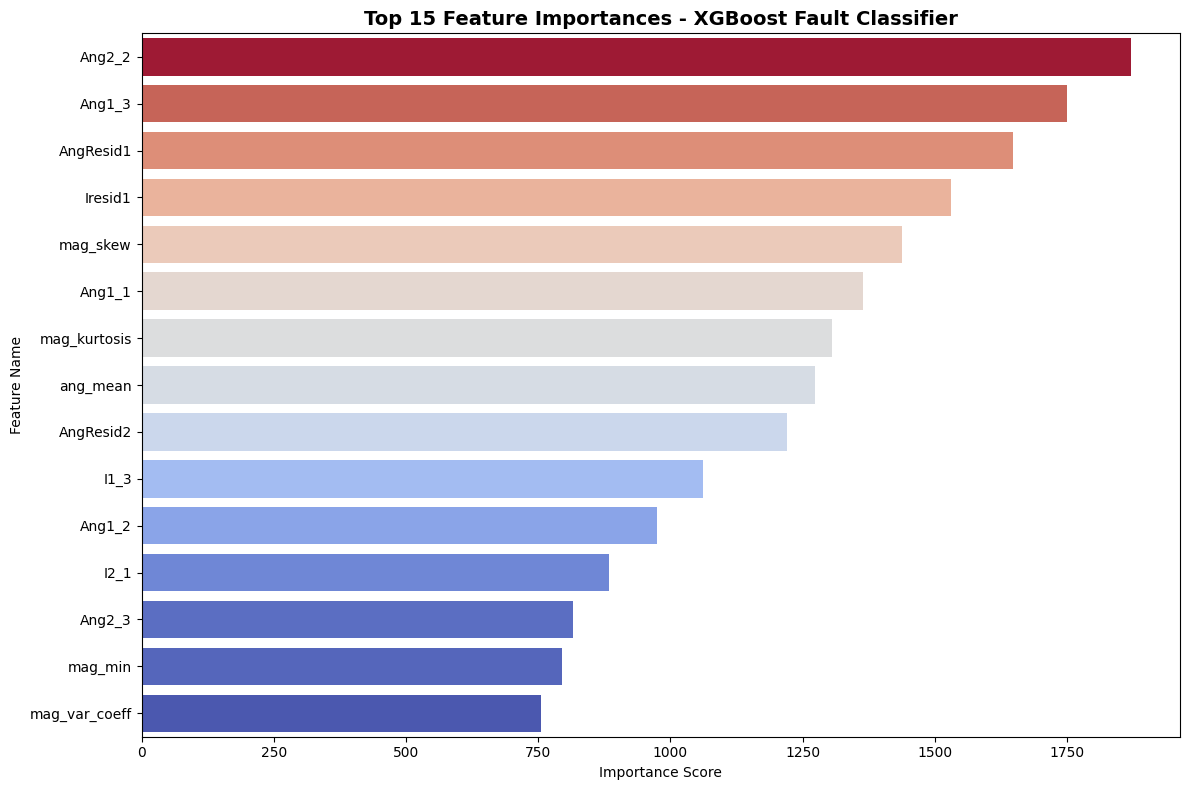

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load the trained ensemble model (VotingClassifier) and selected features
ensemble_model = joblib.load("advanced_fault_classifier_xgb.pkl")  # or advanced_fault_classifier_ensemble.pkl if you renamed
xgb_model = ensemble_model.named_estimators_["xgb"]  # grab the XGBoost part

# Load the feature names you saved during training
selected_features = joblib.load("selected_features.pkl")

# 2) Get raw XGBoost feature importances (f0, f1, f2, ...)
importance_dict = xgb_model.get_booster().get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values()),
})

# 3) Map f0, f1, ... to real feature names
feature_map = {f"f{i}": name for i, name in enumerate(selected_features)}
importance_df["feature_name"] = importance_df["feature"].map(feature_map)

# Drop any unmapped rows and keep top 15
importance_df = (
    importance_df
    .dropna(subset=["feature_name"])
    .sort_values(by="importance", ascending=False)
    .head(15)
)

# 4) Plot
norm = plt.Normalize(importance_df["importance"].min(), importance_df["importance"].max())
colors = plt.cm.coolwarm(norm(importance_df["importance"].values))

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df,
    x="importance",
    y="feature_name",
    palette=colors,
)
plt.title("Top 15 Feature Importances - XGBoost Fault Classifier", fontsize=14, fontweight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


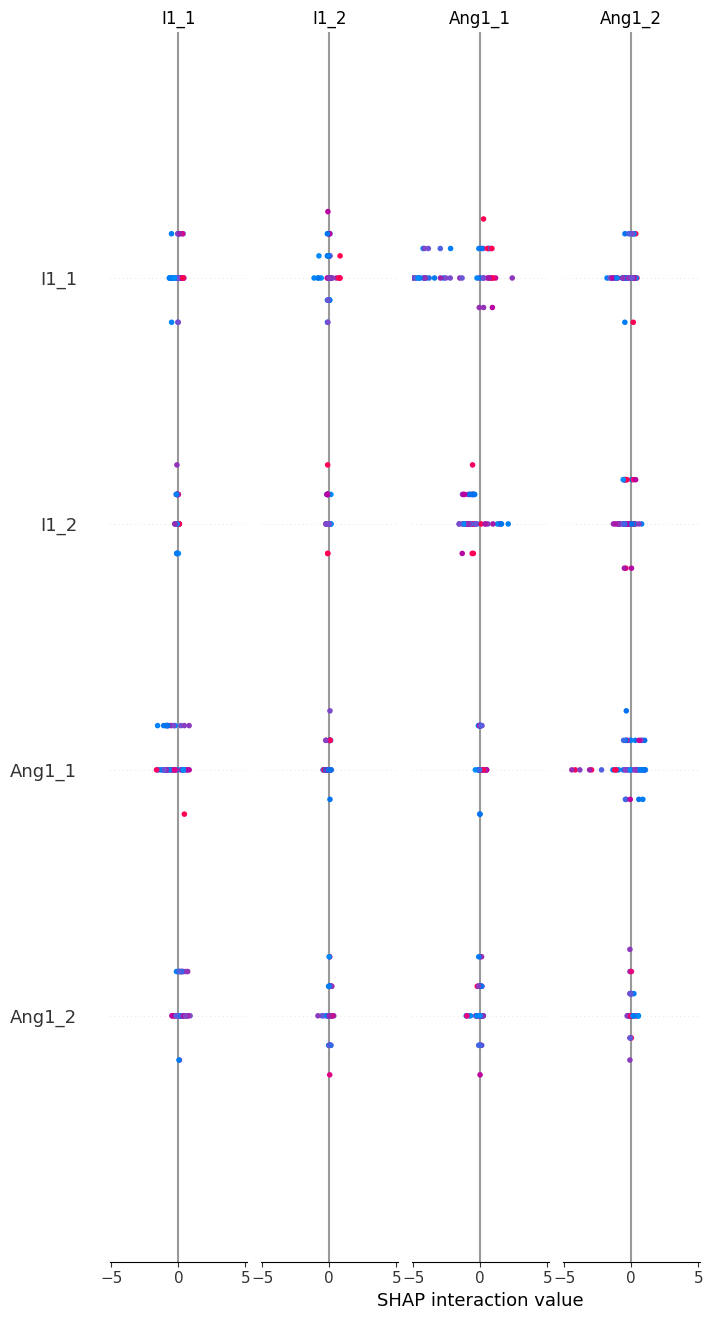

In [ ]:
# === Cell 9: SHAP Summary Plot (Layered Violin) ===

# Build full selected & scaled matrix again for SHAP
X_selected_all_df = X_selected_df.copy()
X_selected_scaled_all = scaler.transform(X_selected_all_df.values)

# Limit to first 50 samples for speed
X_shap = X_selected_all_df.iloc[:50]
X_shap_scaled = X_selected_scaled_all[:50]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap_scaled)

shap.summary_plot(
    shap_values,
    X_shap,
    plot_type='layered_violin',
    max_display=15
)


In [ ]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# SHAP EXPLANATION FOR ADVANCED PIPELINE
# -------------------------------------------------------

# 1) Load trained model, scaler, and feature selector
model = joblib.load('advanced_fault_classifier_xgb.pkl')
scaler = joblib.load('advanced_scaler.pkl')
selector = joblib.load('feature_selector.pkl')

# 2) Rebuild the dataset using the SAME pipeline as training
preprocessor = AdvancedFaultDataPreprocessor()

# Load raw datasets (same paths as in train_advanced_fault_detection_model)
datasets = []

normal_data = preprocessor.load_data(
    '/content/Training Dataset/basecase_currents.csv', fault_type=0
)
if normal_data is not None:
    datasets.append(normal_data)

three_phase_data = preprocessor.load_data(
    '/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx',
    fault_type=1, file_type='excel'
)
if three_phase_data is not None:
    datasets.append(three_phase_data)

ll_data = preprocessor.load_data(
    '/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv',
    fault_type=2
)
if ll_data is not None:
    datasets.append(ll_data)

lg_data = preprocessor.load_data(
    '/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv',
    fault_type=3
)
if lg_data is not None:
    datasets.append(lg_data)

# Concatenate all data
all_data = pd.concat(datasets, ignore_index=True)

# Clean + advanced feature engineering (same as training)
all_data_clean = preprocessor.clean_data(all_data)
all_data_features = preprocessor.advanced_feature_engineering(all_data_clean)

# Use balanced data (same as training before split)
all_data_balanced = preprocessor.smart_balance_data(all_data_features)

# 3) Prepare X, y as in training
y = all_data_balanced['fault_type']
X = all_data_balanced.drop('fault_type', axis=1)
X = X.select_dtypes(include=np.number)

# 4) Apply the SAVED feature selector (do NOT fit again)
X_selected = selector.transform(X)
selected_mask = selector.get_support()
selected_feature_names = X.columns[selected_mask]

X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

# 5) Scale using the SAVED scaler
X_scaled = scaler.transform(X_selected_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_feature_names)

# 6) Limit to a subset (e.g., 200 samples) for SHAP to speed up
X_scaled_subset = X_scaled_df.iloc[:200]

# 7) Create SHAP explainer and compute SHAP values
#    (pattern similar to your original code: Explainer(callable, data))
explainer = shap.Explainer(model.predict, X_scaled_subset)
shap_values = explainer(X_scaled_subset)

# 8) Plot SHAP summary with original (selected) feature names
shap.summary_plot(shap_values, X_scaled_subset, max_display=15)


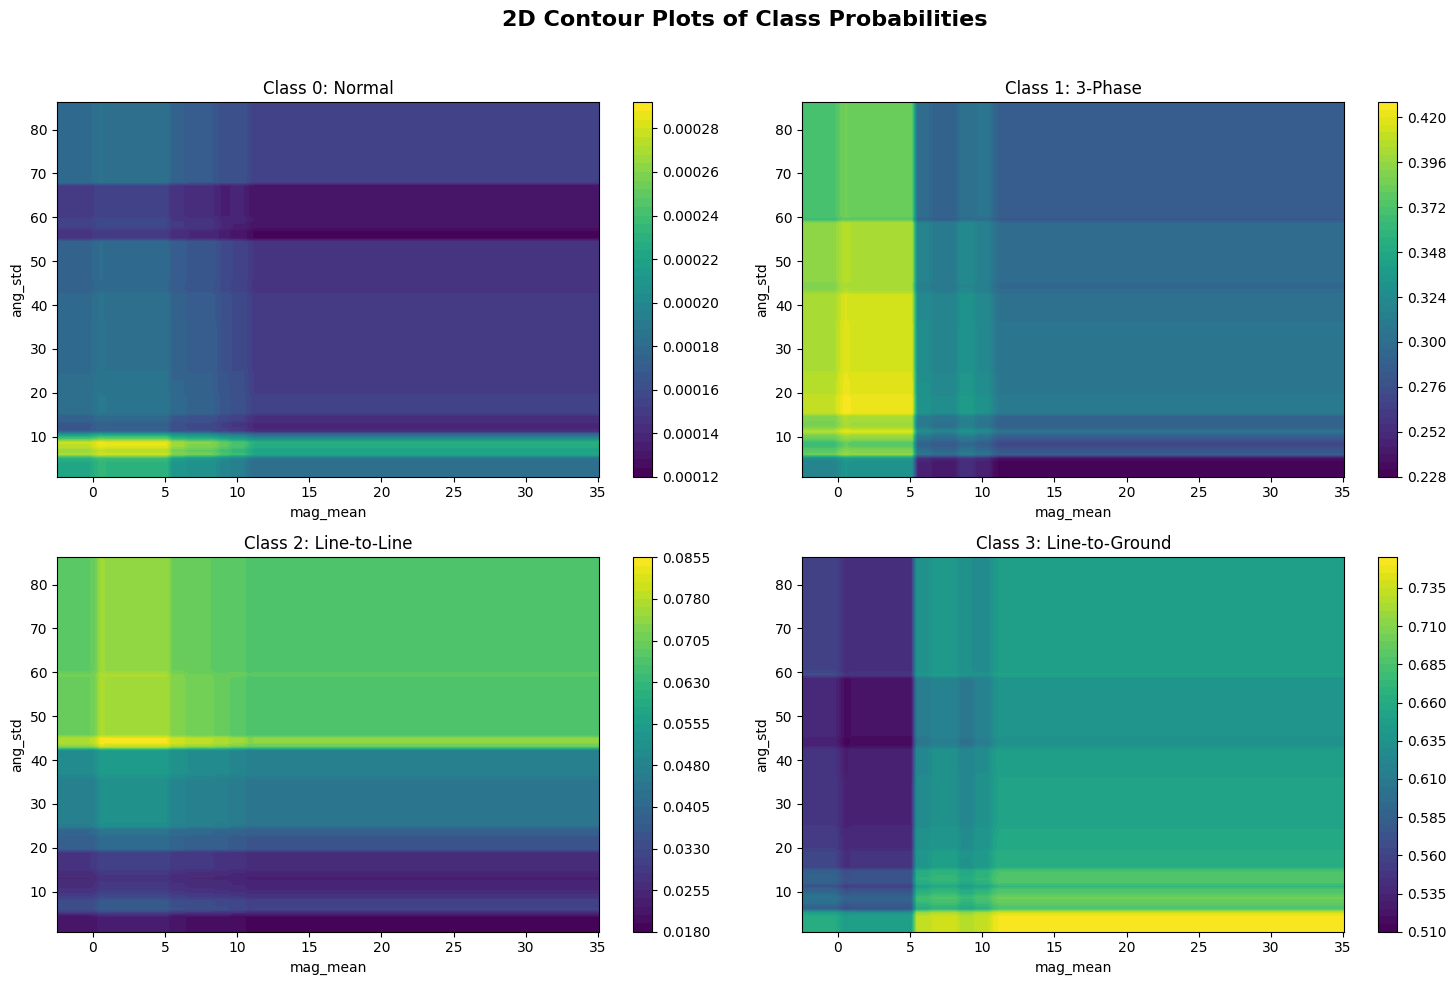

In [ ]:
# === Cell 10: 2D Contour Plots of Class Probabilities (mag_mean vs ang_std) ===

feature_x = 'mag_mean'
feature_y = 'ang_std'

if feature_x not in X_all.columns or feature_y not in X_all.columns:
    raise ValueError("mag_mean and/or ang_std not found in feature set.")

x_vals = np.linspace(X_all[feature_x].min(), X_all[feature_x].max(), 100)
y_vals = np.linspace(X_all[feature_y].min(), X_all[feature_y].max(), 100)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

# Build grid in the space of selected features
grid_dict = {}
for feat in selected_feature_names:
    if feat == feature_x:
        grid_dict[feat] = X_mesh.ravel()
    elif feat == feature_y:
        grid_dict[feat] = Y_mesh.ravel()
    else:
        grid_dict[feat] = X_all[feat].mean()

grid_points = pd.DataFrame(grid_dict, columns=selected_feature_names)

grid_scaled = scaler.transform(grid_points.values)
probs_grid = xgb_model.predict_proba(grid_scaled)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
class_names = ['Normal', '3-Phase', 'Line-to-Line', 'Line-to-Ground']

for i, ax in enumerate(axes.flat):
    Z = probs_grid[:, i].reshape(X_mesh.shape)
    contour = ax.contourf(X_mesh, Y_mesh, Z, levels=50, cmap='viridis')
    fig.colorbar(contour, ax=ax)
    ax.set_title(f'Class {i}: {class_names[i]}')
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

plt.suptitle('2D Contour Plots of Class Probabilities', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



[ROC Prep] Loading datasets...
[ROC Prep] Cleaning...
[ROC Prep] Advanced feature engineering...
[ROC Prep] Smart balancing...
Class 0: 3899 samples
Class 1: 4134 samples
Class 2: 11130 samples
Class 3: 12933 samples
Target size for balancing: 7632

Class distribution after balancing:
  Class 0: 7632 samples
  Class 1: 7632 samples
  Class 2: 7632 samples
  Class 3: 7632 samples
Total balanced samples: 30528
[ROC Prep] Feature matrix shape before selection: (30528, 40)

Generating ROC Curves and AUC...


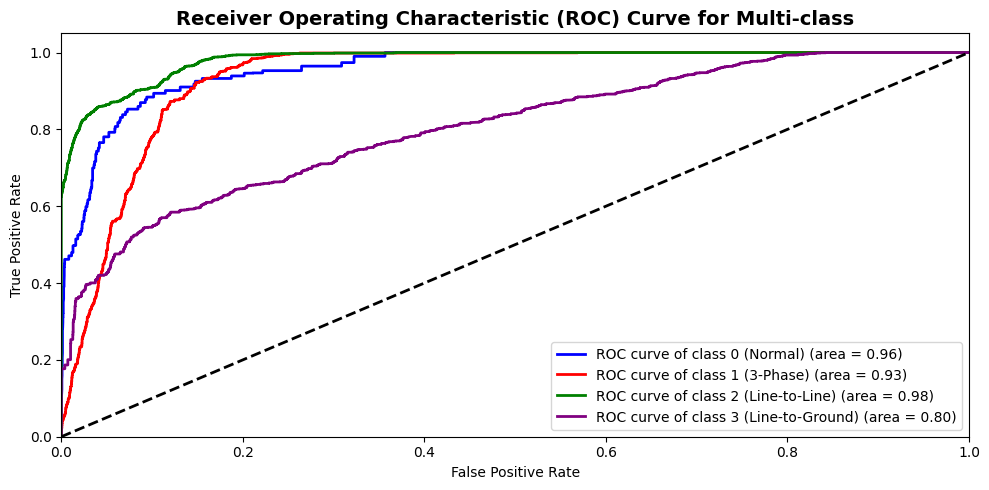

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd

try:
    # Load trained model + preprocessing artifacts
    classifier_model = joblib.load('advanced_fault_classifier_xgb.pkl')
    scaler = joblib.load('advanced_scaler.pkl')
    selector = joblib.load('feature_selector.pkl')

    # Rebuild data using the SAME pipeline as training
    preprocessor = AdvancedFaultDataPreprocessor()

    print("\n[ROC Prep] Loading datasets...")
    datasets = []

    normal_data = preprocessor.load_data(
        '/content/Training Dataset/basecase_currents.csv', fault_type=0
    )
    if normal_data is not None:
        datasets.append(normal_data)

    three_phase_data = preprocessor.load_data(
        '/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx',
        fault_type=1, file_type='excel'
    )
    if three_phase_data is not None:
        datasets.append(three_phase_data)

    ll_data = preprocessor.load_data(
        '/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv',
        fault_type=2
    )
    if ll_data is not None:
        datasets.append(ll_data)

    lg_data = preprocessor.load_data(
        '/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv',
        fault_type=3
    )
    if lg_data is not None:
        datasets.append(lg_data)

    if not datasets:
        raise FileNotFoundError("No datasets loaded")

    all_data = pd.concat(datasets, ignore_index=True)

    print("[ROC Prep] Cleaning...")
    all_data_clean = preprocessor.clean_data(all_data)

    print("[ROC Prep] Advanced feature engineering...")
    all_data_features = preprocessor.advanced_feature_engineering(all_data_clean)

    print("[ROC Prep] Smart balancing...")
    all_data_balanced = preprocessor.smart_balance_data(all_data_features)

    # Prepare X, y
    y = all_data_balanced['fault_type']
    X = all_data_balanced.drop('fault_type', axis=1)
    X = X.select_dtypes(include=np.number)

    print(f"[ROC Prep] Feature matrix shape before selection: {X.shape}")

    # Apply saved feature selector
    X_selected = selector.transform(X)
    X_selected_df = pd.DataFrame(
        X_selected,
        columns=X.columns[selector.get_support()]
    )

    # Train/test split (same ratio & seed as training)
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected_df, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale using saved scaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

except FileNotFoundError as e:
    print("Model or data files not found:", e)
    classifier_model = None
    X_test_scaled = None
    y_test = None

if classifier_model is not None and X_test_scaled is not None and y_test is not None:
    print("\nGenerating ROC Curves and AUC...")

    # Get predicted probabilities for the test set
    y_score = classifier_model.predict_proba(X_test_scaled)

    # Binarize the true labels for each class (0,1,2,3)
    n_classes = 4
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 5))
    colors = ['blue', 'red', 'green', 'purple']
    class_names = ['Normal', '3-Phase', 'Line-to-Line', 'Line-to-Ground']

    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} ({1}) (area = {2:.2f})'
                  ''.format(i, class_names[i], roc_auc[i])
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(
        'Receiver Operating Characteristic (ROC) Curve for Multi-class',
        fontsize=14, fontweight='bold'
    )
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping ROC curve generation due to missing model or data.")



[Corr Prep] Loading datasets...
[Corr Prep] Total samples before balancing: 32096

[Corr Prep] Cleaning...

[Corr Prep] Advanced feature engineering...

[Corr Prep] Smart balancing...
Class 0: 3899 samples
Class 1: 4134 samples
Class 2: 11130 samples
Class 3: 12933 samples
Target size for balancing: 7632

Class distribution after balancing:
  Class 0: 7632 samples
  Class 1: 7632 samples
  Class 2: 7632 samples
  Class 3: 7632 samples
Total balanced samples: 30528
[Corr Prep] Feature matrix before selection: (30528, 40)
[Corr Prep] Feature matrix after selection: (30528, 40)


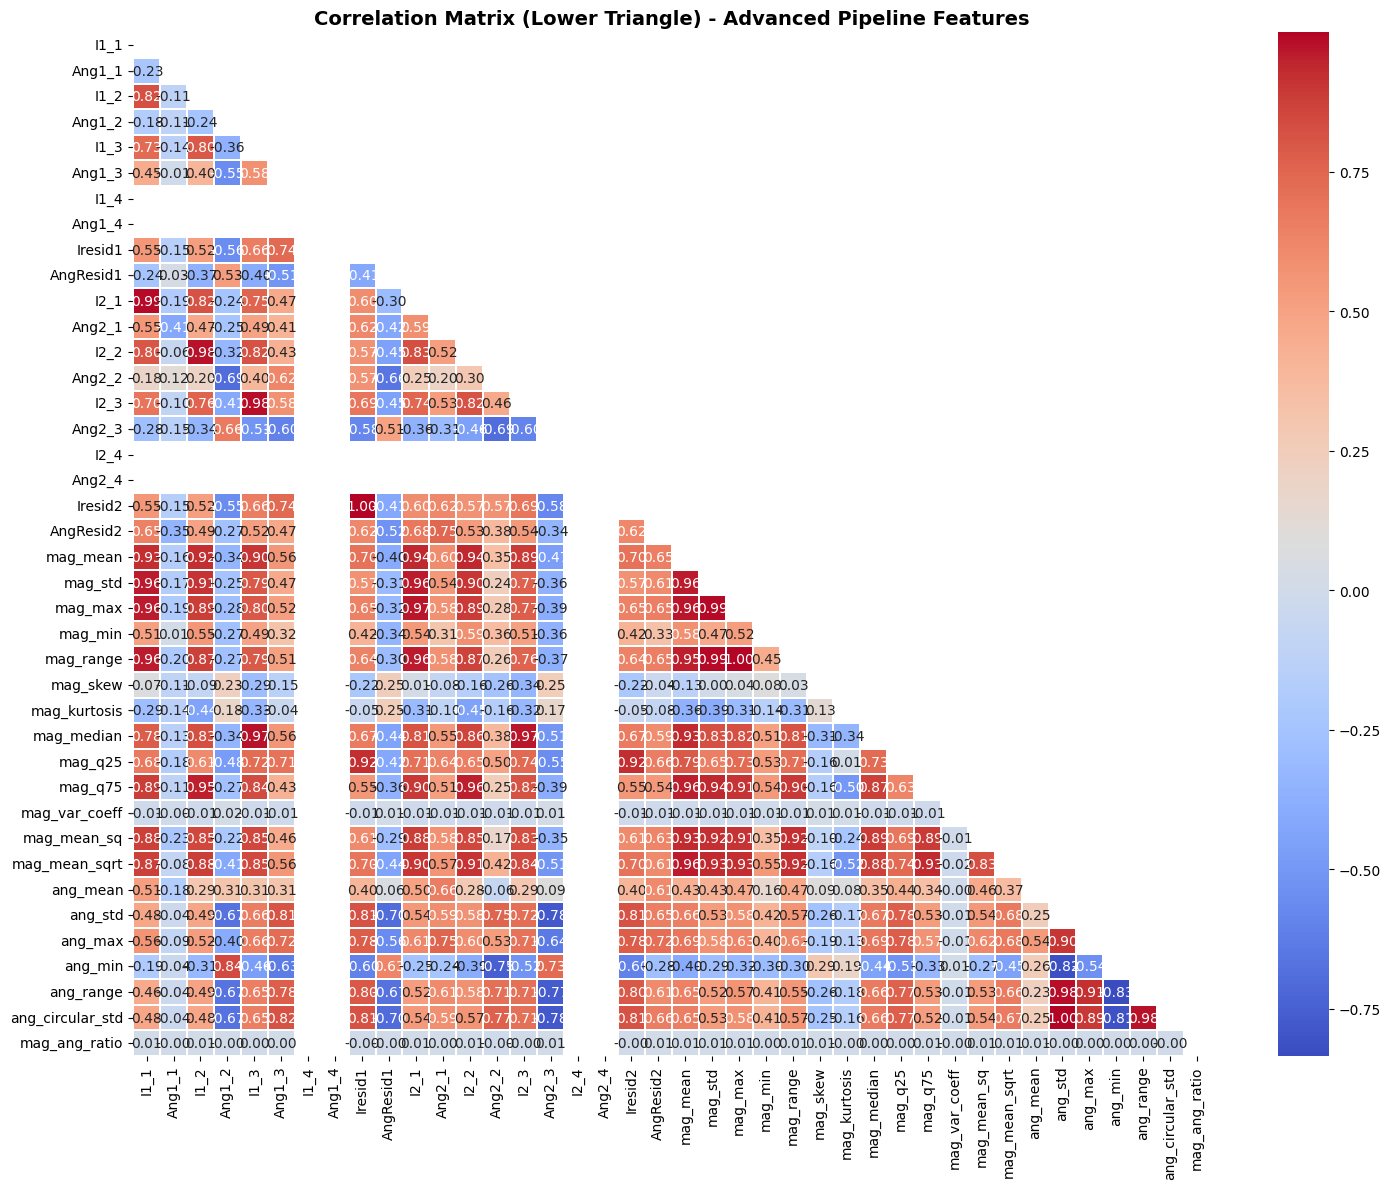

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# ----------------------------------------------------
# Correlation matrix using ADVANCED pipeline artifacts
# ----------------------------------------------------

# Load saved scaler and feature selector from advanced pipeline
scaler = joblib.load('advanced_scaler.pkl')
selector = joblib.load('feature_selector.pkl')

# Use the same preprocessor as in training
preprocessor = AdvancedFaultDataPreprocessor()

print("\n[Corr Prep] Loading datasets...")

datasets = []

normal_data = preprocessor.load_data(
    '/content/Training Dataset/basecase_currents.csv', fault_type=0
)
if normal_data is not None:
    datasets.append(normal_data)

three_phase_data = preprocessor.load_data(
    '/content/Training Dataset/3 Phase Fault/3 Phase Fault.xlsx',
    fault_type=1, file_type='excel'
)
if three_phase_data is not None:
    datasets.append(three_phase_data)

ll_data = preprocessor.load_data(
    '/content/Training Dataset/Line to Line Fault/Line to Line Fault.csv',
    fault_type=2
)
if ll_data is not None:
    datasets.append(ll_data)

lg_data = preprocessor.load_data(
    '/content/Training Dataset/Line to Ground Fault/Line to Ground Fault.csv',
    fault_type=3
)
if lg_data is not None:
    datasets.append(lg_data)

all_data = pd.concat(datasets, ignore_index=True)
print(f"[Corr Prep] Total samples before balancing: {len(all_data)}")

print("\n[Corr Prep] Cleaning...")
all_data_clean = preprocessor.clean_data(all_data)

print("\n[Corr Prep] Advanced feature engineering...")
all_data_features = preprocessor.advanced_feature_engineering(all_data_clean)

print("\n[Corr Prep] Smart balancing...")
all_data_balanced = preprocessor.smart_balance_data(all_data_features)

# Prepare X (numeric features only), y
y = all_data_balanced['fault_type']
X = all_data_balanced.drop('fault_type', axis=1)
X = X.select_dtypes(include=np.number)

print(f"[Corr Prep] Feature matrix before selection: {X.shape}")

# Apply saved feature selector (same as in training)
X_selected = selector.transform(X)
selected_mask = selector.get_support()
selected_feature_names = X.columns[selected_mask]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

print(f"[Corr Prep] Feature matrix after selection: {X_selected_df.shape}")

# Scale using saved scaler
X_scaled = scaler.transform(X_selected_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_feature_names)

# Compute correlation matrix on scaled, selected features
corr = X_scaled_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot lower triangle
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.35
)
plt.title('Correlation Matrix (Lower Triangle) - Advanced Pipeline Features',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
